In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
import numpy as np
from statsmodels.formula.api import ols
from scipy import stats
import statsmodels.formula.api as smf

In [2]:
def filter_variables(df, dict_variables) :
    inicial = True
    for key in dict_variables.keys() :
        if type(dict_variables[key]) == str:
            if inicial :
                filtro = f"({key}\'{dict_variables[key]}\')"
                inicial = False
            else:
                filtro = filtro + f" and ({key}\'{dict_variables[key]}\')"
        else:
            if inicial :
                filtro = f"({key}{dict_variables[key]})"
                inicial = False
            else:
                filtro = filtro + f" and ({key}{dict_variables[key]})"

    return pd.DataFrame(df.query(filtro))

In [3]:
data = pd.read_csv('performances.csv')
data.shape

(20735, 17)

In [4]:
data.head()

,treatment,stage,dyad,player,expert_in,novice_in,round,object,position,kind,classif,accuracy,expert_dog,queried,answer_correct,answered,yes/no
0,single,Training rounds,32519-32519,325192931513079,terrier,hound,1,C11.jpg,frame1,C,C,1,True,NaN,NaN,NaN,NaN
1,single,Training rounds,32519-32519,325192931513079,terrier,hound,1,A1.jpg,frame2,A,C,0,True,NaN,NaN,NaN,NaN
2,single,Training rounds,32519-32519,325192931513079,terrier,hound,1,A7.jpg,frame3,A,A,1,True,NaN,NaN,NaN,NaN
3,single,Training rounds,32519-32519,325192931513079,terrier,hound,1,A6.jpg,frame4,A,A,1,True,NaN,NaN,NaN,NaN
4,single,Training rounds,32519-32519,325192931513079,terrier,hound,1,A5.jpg,frame5,A,A,1,True,NaN,NaN,NaN,NaN


<AxesSubplot:xlabel='round', ylabel='accuracy'>

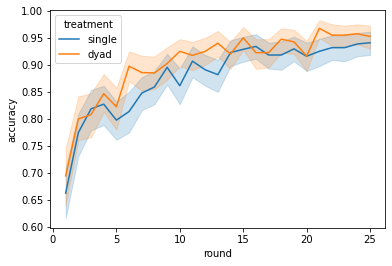

In [5]:
df_game = filter_variables(data, {
    'stage==':'Game rounds'
})
sns.lineplot(x='round', y='accuracy', hue='treatment', data=data)

In [6]:
game_dyad = filter_variables(data, {
    'treatment==':'dyad', 
    'stage==':'Game rounds',
    'expert_dog==':False,
    'round<': 30
})
game_dyad['num_queries'] = game_dyad['queried'].apply(lambda x: x if x>0 else 0)
game_dyad['queried'] = game_dyad['queried'].apply(lambda x: 1 if x>0 else 0)
game_dyad['answer'] = game_dyad['answered'].apply(lambda x: 1 if x>0 else 0)
game_dyad['accuracy_queried'] = game_dyad[['accuracy', 'queried']].apply(lambda x: 1 if ((x['queried']==1) & (x['accuracy']==1)) else 0, axis=1)
game_dyad['accuracy_individual'] = game_dyad[['accuracy', 'queried']].apply(lambda x: 1 if ((x['queried']==0) & (x['accuracy']==1)) else 0, axis=1)
game_dyad.head()

,treatment,stage,dyad,player,expert_in,novice_in,round,object,position,kind,...,accuracy,expert_dog,queried,answer_correct,answered,yes/no,num_queries,answer,accuracy_queried,accuracy_individual
11206,dyad,Game rounds,45981-38174,459819203408978,hound,terrier,1,C1.jpg,frame2,C,...,0,False,0,NaN,NaN,NaN,0.0,0,0,0
11209,dyad,Game rounds,45981-38174,459819203408978,hound,terrier,1,A10.jpg,frame5,A,...,0,False,0,NaN,NaN,NaN,0.0,0,0,0
11210,dyad,Game rounds,45981-38174,38174543864515,terrier,hound,1,B1.jpg,frame1,B,...,1,False,0,NaN,NaN,NaN,0.0,0,0,1
11212,dyad,Game rounds,45981-38174,38174543864515,terrier,hound,1,B5.jpg,frame3,B,...,0,False,0,NaN,NaN,NaN,0.0,0,0,0
11213,dyad,Game rounds,45981-38174,38174543864515,terrier,hound,1,B8.jpg,frame4,B,...,0,False,0,NaN,NaN,NaN,0.0,0,0,0


In [7]:
df_use = game_dyad.groupby(['player', 'kind', 'round']).agg({
    'num_queries':'sum',
    'queried':'mean',
    'yes/no':'mean',
    'accuracy':'mean',
    'accuracy_queried':'mean',
    'accuracy_individual':'mean'
}).reset_index()
#df_use.columns = df_use.columns.get_level_values(0)
#df_use.columns = ['player', 'round', 'num_queries', 'queried', 'yes/no', 'accuracy']
df_use['new_use'] = df_use.groupby('player')['queried'].transform('shift',-1)
df_use.sort_values(by=['player', 'kind', 'round'], inplace=True)
df_use['acc_accuracy'] = df_use.groupby('player')['accuracy'].cumsum()
df_use['acc_queried'] = df_use.groupby('player')['queried'].cumsum()
df_use['acc_precision_individual'] = df_use.groupby('player')['accuracy_individual'].cumsum()
df_use['acc_accuracy_queried'] = df_use.groupby('player')['accuracy_queried'].cumsum()
df_use['A'] = df_use['kind'].apply(lambda x: 1 if x=='A' else 0)
df_use['B'] = df_use['kind'].apply(lambda x: 1 if x=='B' else 0)
df_use['C'] = df_use['kind'].apply(lambda x: 1 if x=='C' else 0)
df_use['D'] = df_use['kind'].apply(lambda x: 1 if x=='D' else 0)
df_use.dropna()
df_use.head()

,player,kind,round,num_queries,queried,yes/no,accuracy,accuracy_queried,accuracy_individual,new_use,acc_accuracy,acc_queried,acc_precision_individual,acc_accuracy_queried,A,B,C,D
0,21409433577947,B,3,2.0,1.000000,0.500000,0.000000,0.000000,0.0,0.333333,0.000000,1.000000,0.0,0.000000,0,1,0,0
1,21409433577947,B,4,2.0,0.333333,0.500000,0.333333,0.333333,0.0,0.500000,0.333333,1.333333,0.0,0.333333,0,1,0,0
2,21409433577947,B,6,4.0,0.500000,0.166667,1.000000,0.500000,0.5,0.500000,1.333333,1.833333,0.5,0.833333,0,1,0,0
3,21409433577947,B,8,2.0,0.500000,0.500000,0.500000,0.500000,0.0,1.000000,1.833333,2.333333,0.5,1.333333,0,1,0,0
4,21409433577947,B,9,1.0,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,2.833333,3.333333,0.5,2.333333,0,1,0,0


In [8]:
mod = smf.ols(formula='new_use ~  queried + acc_precision_individual + acc_accuracy_queried', data=df_use)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                new_use   R-squared:                       0.449
Model:                            OLS   Adj. R-squared:                  0.448
Method:                 Least Squares   F-statistic:                     400.3
Date:                Mon, 08 Nov 2021   Prob (F-statistic):          3.81e-190
Time:                        17:55:58   Log-Likelihood:                -512.87
No. Observations:                1478   AIC:                             1034.
Df Residuals:                    1474   BIC:                             1055.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

<AxesSubplot:ylabel='Count'>

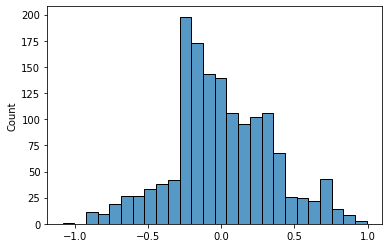

In [13]:
residuos = df_use['new_use'] - res.fittedvalues
sns.histplot(residuos)

In [ ]:
mod = smf.ols(formula='new_use ~  queried + acc_precision_individual + acc_accuracy_queried + A + B + C + D', data=df_use)
res = mod.fit()
print(res.summary())

In [ ]:
df_use[['queried', 'acc_precision_individual', 'acc_accuracy_queried', 'A', 'B', 'C', 'D']].corr()


In [ ]:
df_use.groupby('player')['acc_queried'].max().describe()

In [ ]:
sns.distplot(df_use.groupby('player')['acc_queried'].max())

In [ ]:
df_use['use_grp'] = pd.cut(df_use['acc_queried'], 
                                   bins=[0, 2.2, 7.5, 16.8, 25], 
                                   include_lowest=True, 
                                   labels=['very_low', 'low', 'mid', 'high'])
df_use.head()

In [ ]:
df_extremes = df_use[(df_use['use_grp']=='very_low') | (df_use['use_grp']=='high')]
sns.lineplot(x='round', y='accuracy', hue='use_grp', data=df_extremes)

In [ ]:
ps = []
rounds = []
for round, grp in df_extremes.groupby('round'):
    dats = grp[grp['use_grp']=='very_low']
    a = dats['accuracy'].to_list()
    dats = grp[grp['use_grp']=='high']
    b = dats['accuracy'].to_list()
    t_value,p_value=stats.ttest_ind(a,b)
    ps.append(p_value)
    rounds.append(round)
    
fig, ax = plt.subplots()
sns.lineplot(y=ps, x=rounds, ax=ax)
ax.set_ylim([0,1])

In [ ]:
a = df_use[df_use['use_grp']=='very_low']['accuracy'].tolist()
b= df_use[df_use['use_grp']=='high']['accuracy'].tolist()
t_value,p_value=stats.ttest_ind(a,b)
print(p_value)

In [ ]:
sns.boxplot(x='use_grp', y='accuracy', data=df_extremes)

In [ ]:
sns.lineplot(x='round', y='queried', data=df_use)

In [ ]:
df_no_use = filter_variables(df_use, {
    'acc_queried<':3, 
    'round<':8
})

In [ ]:
df_no_use.groupby('player')['acc_queried'].max().describe()

In [ ]:
sns.distplot(df_no_use.groupby('player')['acc_queried'].max())

In [ ]:
sns.regplot(x='acc_accuracy', 
            y='new_use', 
            data=df_no_use, 
            scatter_kws={'alpha':0.5})

In [ ]:
df_use['round'].unique()

In [ ]:
df_lots_of_use = filter_variables(df_use, {
    'acc_queried>':8, 
    'round>':19
})
sns.regplot(x='acc_accuracy', 
            y='new_use', 
            data=df_lots_of_use, 
            scatter_kws={'alpha':0.5})

In [ ]:
game_dyad['yes/no'].describe()

In [ ]:
df_inbetween = filter_variables(df_use, {
    'acc_queried>':2, 
    'acc_queried<':7
})
df_inbetween.head()

In [ ]:
sns.regplot(x='acc_cost', y='new_use', data=df_use, 
            scatter_kws={'alpha':0.5})